## Download the road network of La Spezia (Italy) from OSMWebWizard:

* Create a python function that, given a list of tuples in the form _(type, 
n_vehicles, edge_list, departure_time)_ creates an xml file describing the 
corresponding traffic demand; use the script to compute the traffic demand for 
the following points. Type can be route or flow.

* Create a traffic demand of 1,000 vehicles moving through a random origin 
and destination edges. Ensure that origin and destination are connected. 
Departure time is chosen uniformly at random in [0, 600].


* Apply duarouter to the mobility demand for w=1, 5, 10, 15, 20. Compute, for 
each value of w, the total distance traveled, the difference with respect to the 
shortest path, and the total CO2 emissions.

# Importing La_spezia Road Network

In [1]:
import random
import matplotlib.pyplot as plt

In [2]:
import sumolib

# read the road network
net = sumolib.net.readNet('road_network_la_spezia.net.xml')

In [3]:
#List of edges in the map
edge_list = net.getEdges()
edge_list_ids = [edge.getID() for edge in edge_list]

edge_list_ids[:5]

['-100467520', '-100467523#0', '-100467523#1', '-100467523#2', '-101081095#0']

# Initializing traffic_demand.rou.xml file

1. _Create a python function that, given a list of tuples in the form _(type, 
n_vehicles, edge_list, departure_time)_ creates an xml file describing the 
corresponding traffic demand; use the script to compute the traffic demand for 
the following points. Type can be route or flow._

In [4]:
def create_traffic_xml(vtype:str, n_vheicles:int, edge_list:list, departure_time: int = 0) -> (list, float):
    random.seed(3)
    departures_arrivals = []
    shortest_path = float(0)
    
    # # creating generator with colours
    # for j in range(n_vheicles):
    #     rand_colors = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    
    #constructing the xml file
    with open("traffic_demand_la_spezia.rou.xml", "w") as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?> \n\n')
        f.write('<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n\n')
        f.write(f'    <vType id="type1" vClass="{vtype}"/> \n\n')
        
        for i in range(n_vheicles):
            #color = None
            departure, arrival = None, None
            path, distance = None, None
            while not path:
                departure, arrival = random.sample(edge_list, 2)
                path, distance = net.getShortestPath(departure, arrival)
            departures_arrivals.append((departure, arrival))
            shortest_path += distance
            
            departure, arrival= departure.getID(), arrival.getID()
            f.write(f'    <flow id="flow_{str(i)}" begin="{departure_time}" end="1500" number="1" from="{departure}" to="{arrival}" type="type1" color="green"></flow>\n')
        f.write("\n\n")
        f.write("</routes>")
            
    return departures_arrivals, shortest_path

2. _Create a traffic demand of 1,000 vehicles moving through a random origin 
and destination edges. Ensure that origin and destination are connected. 
Departure time is chosen uniformly at random in [0, 600]._

In [5]:
#chosing random departure_time
departure_time = random.choice(range(601))

departures_arrivals, shortest_path = create_traffic_xml("taxi", 100, edge_list, departure_time) #put 1000 

In [6]:
departures_arrivals[0]

(<edge id="-849508904" from="7925641485" to="1951608811"/>,
 <edge id="494955624#10" from="9784955071" to="9784987238"/>)

In [7]:
print(f"Shortest Path Distance [Kms]: {shortest_path/1000:,.2f} ")

Shortest Path Distance [Kms]: 276.85 


## Transforming incomplete Routes to Routes

In [8]:
import subprocess

# prepare the command string for duarouter

command_str = "duarouter --route-files traffic_demand_la_spezia.rou.xml "+\
        " --net-file road_network_la_spezia.net.xml"+\
        f" --output-file traffic_demand_la_spezia_duarouter.rou.xml --weights.random-factor 1"

In [9]:
p = subprocess.Popen(command_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
retval = p.wait()

In [10]:
print(p)

<Popen: returncode: 0 args: 'duarouter --route-files traffic_demand_la_spezi...>


# TraCi

In [11]:
# import the traci library
import traci
from utils import init_traci

In [12]:
def distance_co2Emissions() -> tuple:
    
    """
    Returning the Total amout of Co2 [mg] produced in the simulation and the relative Total Distance [m] traveled.
    
    The 'veichles' hashmap represent the result of every veichle at the end of the simulation, and takes the form of:
    
    'flow_0.0': {'co2_emissions': 346551.72927755694, 'distance': 956.4000691741918, 'time': 64},
    'flow_1.0': {'co2_emissions': 1952854.7385415002, 'distance': 7254.69168403833, 'time': 619} 
    ..
    'flow_16.0': {'co2_emissions': 1724971.323013863, 'distance': 6756.51903673607, 'time': 571}
    ..
    """
    
    traci.start(['sumo', '-c', 'la_spezia.sumocfg'])
    vehicles = dict()
    tot_co2, tot_distance = 0, 0
    
    # simulate each step
    for step in range(departure_time,2000): # assuming to be above the finishing time
        
        # perform a simulation step
        traci.simulationStep()
        vehicle_list = set(traci.vehicle.getIDList())
        
        # value retrieval
        if vehicle_list:
            for v_id in vehicle_list:
                if v_id not in vehicles:
                    #initializing dictionary's record
                    vehicles[v_id] = {"co2_emissions" : 0, "distance": 0, "time": 0} 

                # CO2 emissions [mg/s] 
                # adding up each co2_emissions amount for every veichle to it's reference in the dictionary
                co2_emissions = traci.vehicle.getCO2Emission(v_id)
                vehicles[v_id]["co2_emissions"] += co2_emissions

                # distance [meters]
                partial_distance = traci.vehicle.getDistance(v_id)
                vehicles[v_id]["distance"] = partial_distance
                vehicles[v_id]["time"] += 1
        
                # print(f"Vehicle ID: {v_id}")
                # print(f"CO2 emissions [mg/s]: {co2_emissions}\n")
    
            
    # close TraCi when the total number of steps to simulate is reached
    time = max([vehicle["time"] for vehicle in vehicles.values()])
    for veichle in vehicles.values():
        tot_co2 += veichle["co2_emissions"]
        tot_distance += veichle["distance"]
        
    traci.close()
    return tot_co2, tot_distance, time

In [13]:
# help(distance_co2Emissions)

In [14]:
w0_co2, w0_distance, max_time = distance_co2Emissions()

In [15]:
# #To run in case of Sump/Traci connection errors:
# traci.close()

In [16]:
round(w0_co2/1000,2), round(w0_distance/1000,2)

(93696.32, 337.02)

In [17]:
max_time

614

# Dealing with Random Perturbation (W)

3. _Apply duarouter to the mobility demand for w=1, 5, 10, 15, 20. Compute, for 
each value of w, the total distance traveled, the difference with respect to the 
shortest path, and the total CO2 emissions._

In [18]:
def duaroute_command_string(w: int) -> str:
    res = "duarouter --route-files traffic_demand_la_spezia.rou.xml "+\
        " --net-file road_network_la_spezia.net.xml"+\
        f" --output-file traffic_demand_la_spezia_duarouter.rou.xml --weights.random-factor {w}"
    return res

In [19]:
def making_duaroute_xml(w: int):
    command_str = duaroute_command_string(w)
    p = subprocess.Popen(command_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    retval = p.wait()

In [20]:
duaroute_command_string(999)

'duarouter --route-files traffic_demand_la_spezia.rou.xml  --net-file road_network_la_spezia.net.xml --output-file traffic_demand_la_spezia_duarouter.rou.xml --weights.random-factor 999'

In [21]:
from tqdm import tqdm
# perturbations
W = [1] + list(range(5,21,5))

In [22]:
# (it takes a while)
output = [(w0_co2, w0_distance, max_time)]
for i in tqdm(range(1, len(W))):
    making_duaroute_xml(W[i])
    output.append(distance_co2Emissions())

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:41<00:00, 10.33s/it]


In [23]:
output = [(round(co2,2), round(distance,2), time_units) for co2,distance,time_units in output]

print(f"Shortest Path Distance [Kms]: {shortest_path/1000:,.2f} ")
for i in range(len(output)):
    print(f"Weight: {W[i]:>3}  -  Total Distance [Kms]: {output[i][1]/1000:,.2f}  \t  Total Co2 emitted [mg]: {output[i][0]:_.2f}  \t  " + \
         f"Travel Time [s]: {output[i][2]}")

Shortest Path Distance [Kms]: 276.85 
Weight:   1  -  Total Distance [Kms]: 337.02  	  Total Co2 emitted [mg]: 93_696_321.34  	  Travel Time [s]: 614
Weight:   5  -  Total Distance [Kms]: 338.89  	  Total Co2 emitted [mg]: 95_288_745.51  	  Travel Time [s]: 652
Weight:  10  -  Total Distance [Kms]: 343.97  	  Total Co2 emitted [mg]: 95_885_768.83  	  Travel Time [s]: 652
Weight:  15  -  Total Distance [Kms]: 340.87  	  Total Co2 emitted [mg]: 96_077_736.84  	  Travel Time [s]: 651
Weight:  20  -  Total Distance [Kms]: 347.41  	  Total Co2 emitted [mg]: 97_151_152.78  	  Travel Time [s]: 668


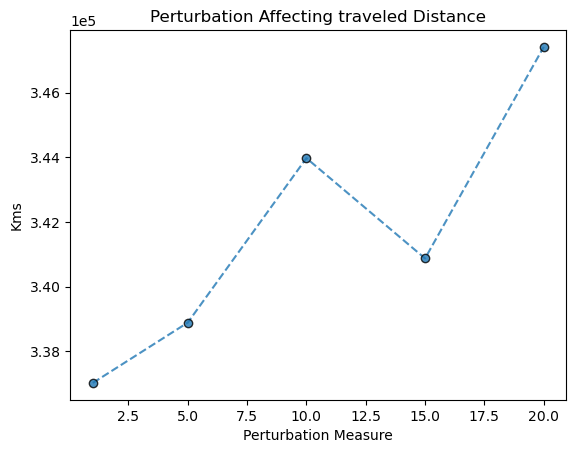

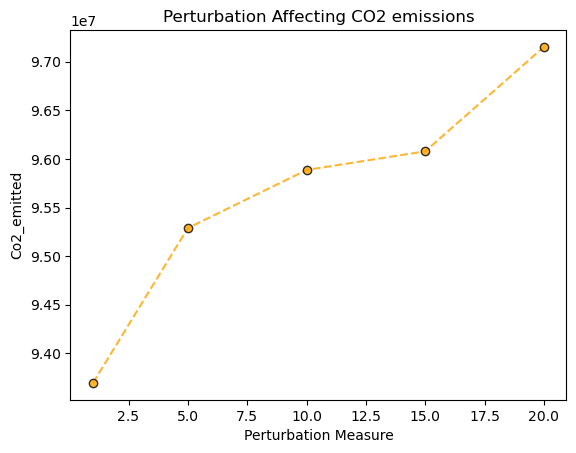

In [24]:
ax = plt.subplot()
plt.plot(W,[distance for _,distance,_ in output], 
         marker= "o", alpha=0.8, markeredgecolor="black", linestyle="--")
plt.xlabel("Perturbation Measure")
plt.ylabel("Kms")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("Perturbation Affecting traveled Distance", size=12)
plt.show()

ax = plt.subplot()
plt.plot(W,[co2 for co2,_,_ in output], 
         marker= "o", alpha=0.8, markeredgecolor="black", linestyle="--", color="orange")
plt.xlabel("Perturbation Measure")
plt.ylabel("Co2_emitted")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("Perturbation Affecting CO2 emissions", size=12)
plt.show()